# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и предварительное изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.dummy import DummyRegressor

In [2]:
def basic_data_info(data):
    print('Первые пять строк:')
    display(data.head())
    print('\nИнформация:')
    print(data.info())
    print('\nНаличие пропусков:')
    print(data.isna().sum())
    print('\nНаличие дубликатов:')
    print(data.duplicated().sum())
    print('\nСтатистическое описание данных:')
    print(data.describe())

In [3]:
autos = pd.read_csv('/datasets/autos.csv')

In [4]:
basic_data_info(autos)

Первые пять строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int6

Мы загрузили данные в датафрейм `autos`. Датафрейм содержит 354369 строк-наблюдений. В данных 16 колонок:

- `DateCrawled`: строковые данные, пропусков нет.
- `Price`: целочисленные данные типа `int64`, пропусков нет. 
- `VehicleType`: строковые данные, 37490 пропусков.
- `RegistrationYear`: целочисленные данные типа `int64`, пропусков нет. 
- `Gearbox`: строковые данные, 19833 пропусков.
- `Power`: целочисленные данные типа `int64`, пропусков нет. 
- `Model`:  строковые даннеы, 19705 пропусков.
- `Kilometer`: целочисленные данные типа `int64`, пропусков нет. 
- `RegistrationMonth`: целочисленные данные типа `int64`, пропусков нет. 
- `FuelType`: строковые данные, 32895 пропусков.
- `Brand`: строковые данные, пропусков нет.
- `Repaired`: строковые данные, 71154 пропусков.
- `DateCreated`: строковые данные, пропусков нет.
- `NumberOfPictures`: целочисленные данные типа `int64`, пропусков нет. 
- `PostalCode`: целочисленные данные типа `int64`, пропусков нет.

В данных имеется 4 строки-дубликата.

### Предобработка данных

#### Обработка дубликатов
Было обнаружено, что в данных имеется 4 строки-дубликата. Предлагается удалить эти строки.

In [5]:
autos = autos.drop_duplicates(ignore_index=True)

In [6]:
autos.shape

(354365, 16)

#### Обработка пропусков

In [7]:
print('Относительная частота пропусков в каждом столбце:')
(autos.isna().mean() * 100).sort_values(ascending=False)

Относительная частота пропусков в каждом столбце:


Repaired             20.079297
VehicleType          10.579487
FuelType              9.282802
Gearbox               5.596772
Model                 5.560651
DateCrawled           0.000000
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
Brand                 0.000000
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

##### Признак `Repaired`
В колонке `Repaired` пропущено 20% данных. Признак является категориальным, машина либо была в ремонте, либо не была.

In [8]:
autos['Repaired'].value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

Если информация о машинах заполнялась вручную, но причиной пропуска может быть человеческий фактор: если машина не была в ремонте, то люди могли ничего не отмечать в соответствующей колонке, т.е. тогда пропуск можно приравнять к значению `no`.

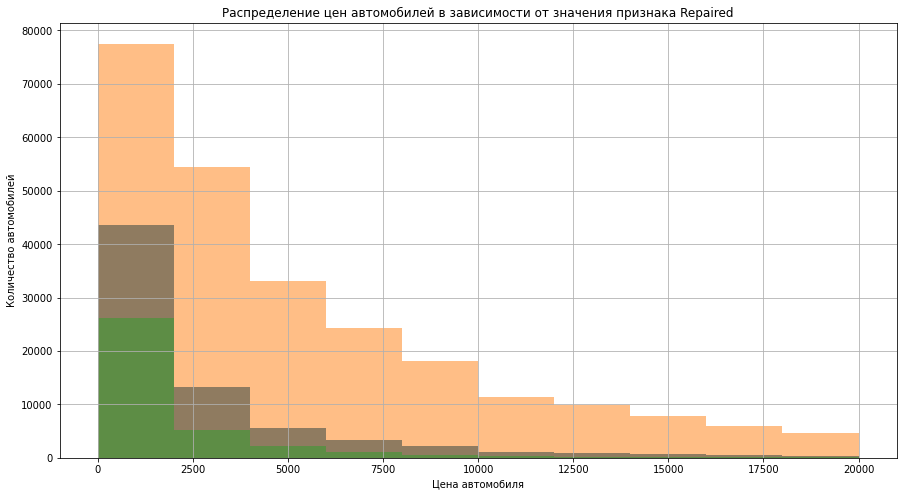

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
autos[autos['Repaired'].isna()]['Price'].hist()
autos[autos['Repaired'] == 'no']['Price'].hist(alpha=0.5)
autos[autos['Repaired'] == 'yes']['Price'].hist(alpha=0.5)
plt.title('Распределение цен автомобилей в зависимости от значения признака Repaired')
plt.xlabel('Цена автомобиля')
plt.ylabel('Количество автомобилей')
plt.show()

In [10]:
autos[autos['Repaired'].isna()]['Price'].mean()

2626.4192455800094

In [11]:
autos[autos['Repaired'] == 'no']['Price'].mean()

5296.856015180573

In [12]:
autos[autos['Repaired'] == 'yes']['Price'].mean()

1915.961889440546

Однако, если мы сравним средние значения целеового признака `Price` у этих категорий, мы увидим, что среднее значение цен подвыборки машин, которые были в ремонте, ниже среднего значения цены машин, у которых в этой колонке пропуск. Я прелагаю заполнить пропуск значением-заглушкой `unknown`.

In [13]:
autos['Repaired'] = autos['Repaired'].fillna('unknown')

In [14]:
autos['Repaired'].isna().sum()

0

##### Признак `VehicleType`

In [15]:
autos['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [16]:
autos['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

Предлагаю снова заменить пропуски заглушкой `unknown`.

In [17]:
autos['VehicleType'] = autos['VehicleType'].fillna('unknown')

In [18]:
autos['VehicleType'].isna().sum()

0

##### Признак `FuelType`

In [19]:
autos['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [20]:
autos['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Снова используем заглушку `unknown`.

In [21]:
autos['FuelType'] = autos['FuelType'].fillna('unknown')

In [22]:
autos['FuelType'].isna().sum()

0

##### Признаки `Gearbox` и `Model`
Пропуски в этих колонках осставляют по 5%, можно удалить пропсуки из данных.

In [23]:
autos = autos.dropna(subset = ['Gearbox', 'Model']).reset_index().drop('index', axis=1)

In [24]:
autos.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Мы обработали все пропуски.

#### Преобразование типов данных
В колонках `DateCrawled`, `DateCreated`, и `LastSeen` хранится информация о датах, но тип данных не соответствует типу информации. Предлагаю преобразовать данные в тип `datetime`. 

In [25]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
3,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [26]:
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'], format='%Y-%m-%d %H:%M:%S')

In [27]:
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'], format='%Y-%m-%d %H:%M:%S')

In [28]:
autos['LastSeen'] = pd.to_datetime(autos['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [29]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318958 entries, 0 to 318957
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        318958 non-null  datetime64[ns]
 1   Price              318958 non-null  int64         
 2   VehicleType        318958 non-null  object        
 3   RegistrationYear   318958 non-null  int64         
 4   Gearbox            318958 non-null  object        
 5   Power              318958 non-null  int64         
 6   Model              318958 non-null  object        
 7   Kilometer          318958 non-null  int64         
 8   RegistrationMonth  318958 non-null  int64         
 9   FuelType           318958 non-null  object        
 10  Brand              318958 non-null  object        
 11  Repaired           318958 non-null  object        
 12  DateCreated        318958 non-null  datetime64[ns]
 13  NumberOfPictures   318958 non-null  int64   

#### Обработка аномалий

Сначала еще раз применим метод `describe` к нашему датафрейму.

In [30]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,318958.000000,318958.000000,318958.000000,318958.000000,318958.000000,318958.0,318958.000000
mean,4608.905502,2003.427031,114.965265,128844.738179,5.908107,0.0,50766.394149
std,4564.241216,30.517461,185.627579,36620.680186,3.634281,0.0,25780.246706
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30455.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.000000
75%,6700.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71357.000000
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Видим аномальные значения в колонках `Price`, `RegistratonYear`, `Power`, `RegistrationMonth`. Рассмотрим эти признаки подробнее.

##### Признак `Price`

In [31]:
autos[autos.Price == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
6,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
99,2016-03-19 18:40:12,0,unknown,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,2016-03-19,0,21698,2016-04-01 08:47:05
135,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,0,27432,2016-03-12 23:47:10
207,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,unknown,ford,unknown,2016-03-16,0,57627,2016-03-26 11:17:50
414,2016-03-24 10:58:40,0,unknown,2016,auto,197,3er,150000,12,gasoline,bmw,no,2016-03-24,0,99867,2016-03-25 19:46:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318809,2016-03-09 15:56:30,0,unknown,2000,manual,65,corsa,150000,0,unknown,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08
318838,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,2016-03-20,0,33659,2016-04-06 18:45:23
318847,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,2016-03-24,0,42329,2016-04-07 05:17:24
318874,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32


Видим, что в данных есть 7156 строк, где цена равна 0. Это странное значение, предлагаю удалить из данных эти строки.

In [32]:
autos = autos[autos.Price != 0]

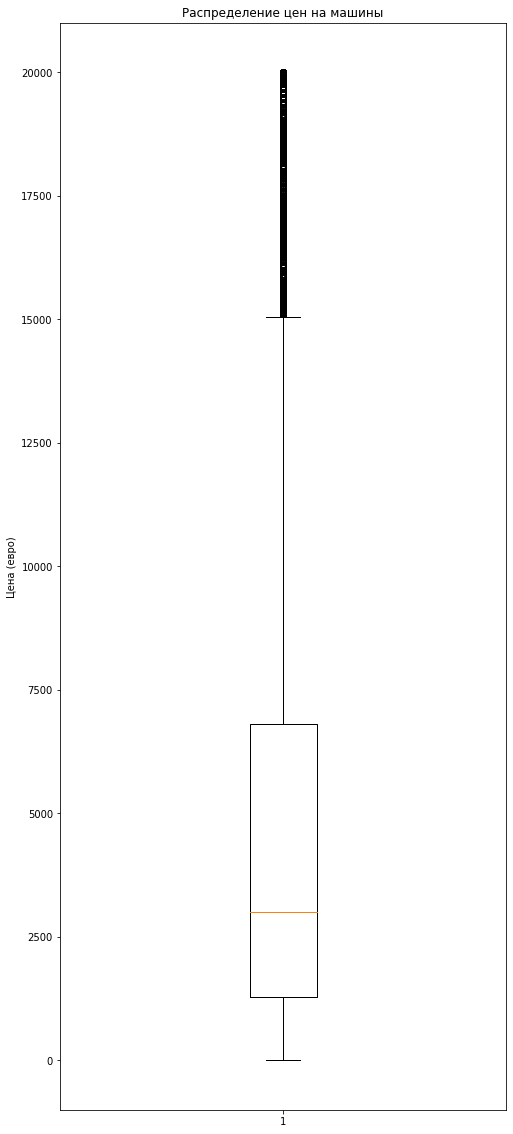

In [33]:
fig, ax = plt.subplots(figsize=(8, 20))
plt.boxplot(autos['Price'])
plt.title('Распределение цен на машины')
plt.ylabel('Цена (евро)')
plt.show()

In [34]:
autos[autos.Price <= 10]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
80,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54
241,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11,0,55122,2016-03-26 23:15:49
807,2016-03-06 00:25:25,1,unknown,1990,manual,0,other,150000,0,unknown,porsche,unknown,2016-03-05,0,65843,2016-04-06 20:19:08
865,2016-03-23 08:21:11,1,wagon,1998,manual,136,omega,150000,0,petrol,opel,no,2016-03-22,0,57614,2016-03-27 08:45:52
913,2016-03-15 18:57:12,3,convertible,1998,manual,110,mx_reihe,150000,11,unknown,mazda,yes,2016-03-15,0,89312,2016-04-06 21:16:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317793,2016-03-22 19:43:53,1,small,2000,manual,100,corsa,150000,6,gasoline,opel,unknown,2016-03-22,0,4654,2016-04-06 12:16:06
317849,2016-03-10 17:47:24,1,wagon,2007,auto,200,3er,150000,6,gasoline,bmw,no,2016-03-10,0,90574,2016-03-12 23:15:59
317941,2016-03-09 13:48:39,1,coupe,1990,manual,45,polo,150000,0,petrol,volkswagen,no,2016-03-09,0,26160,2016-03-25 07:18:43
318326,2016-03-07 13:53:17,1,bus,1999,manual,0,espace,150000,0,petrol,renault,unknown,2016-03-07,0,57439,2016-03-08 16:51:26


На диаграмме с усами нет выбросов в нижей части графика, однако есть выбросы в верхней части. Однако, дорогие машины выглядят менее аномальными, чем машины, цена которых ниже 10 евро, а таких машин в данных 782. Предлагаю их тоже удалить из данных.

In [35]:
autos = autos[autos.Price > 10]

Нижний порог для цены можно было бы повышать и дальше, но предлагаю пока предположить, что 11 евро - это уже не такая аномальная цена.

##### Признак `RegistratonYear`

In [36]:
sorted(autos['RegistrationYear'].unique())

[1000,
 1400,
 1500,
 1600,
 1602,
 1910,
 1923,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1942,
 1943,
 1945,
 1947,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2900,
 3700,
 4000,
 4500,
 5000,
 5911,
 6000,
 7100,
 8200]

Аномальными выглядят все значения, меньше 1910. Также проверим дату выгрузки данных из базы, чтобы определить верхнюю допустимую границу.

In [37]:
autos['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

Таким образом, верхняя граница - это 2016 год. Удалим данные, выходящие за наши границы.

In [38]:
autos = autos[(autos['RegistrationYear'] >= 1910) & (autos['RegistrationYear'] <= 2016)]

##### Признак `Power`

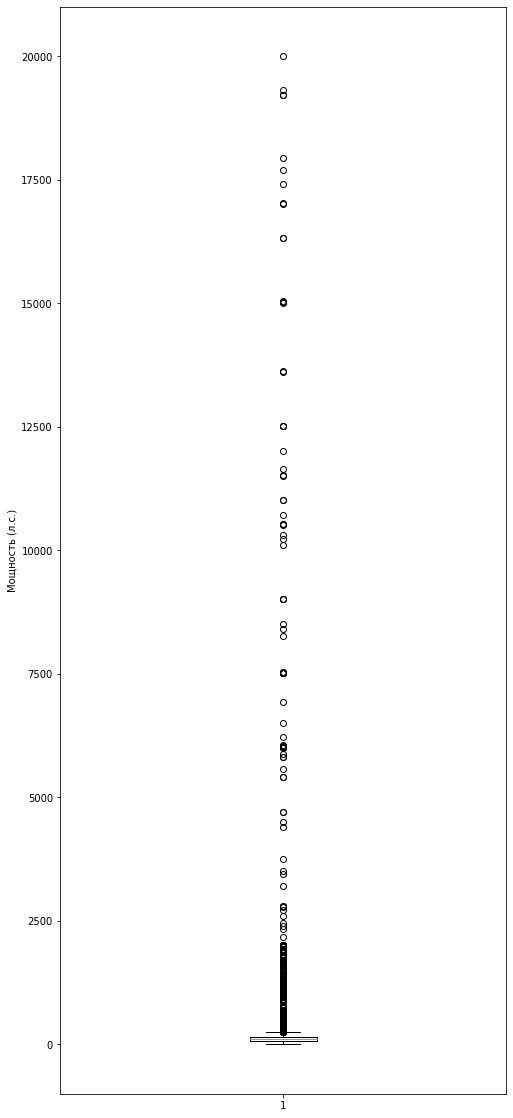

In [39]:
fig, ax = plt.subplots(figsize=(8, 20))
plt.boxplot(autos['Power'])
plt.ylabel('Мощность (л.с.)')
plt.show()

Видим много выбросов в верхней части графика. Я не очень хорошо разбираюсь в мощности автомобилей, но предлагаю выбрать для значений верхнюю границу, равную 500 л.с.

In [40]:
autos = autos[autos['Power'] < 500]

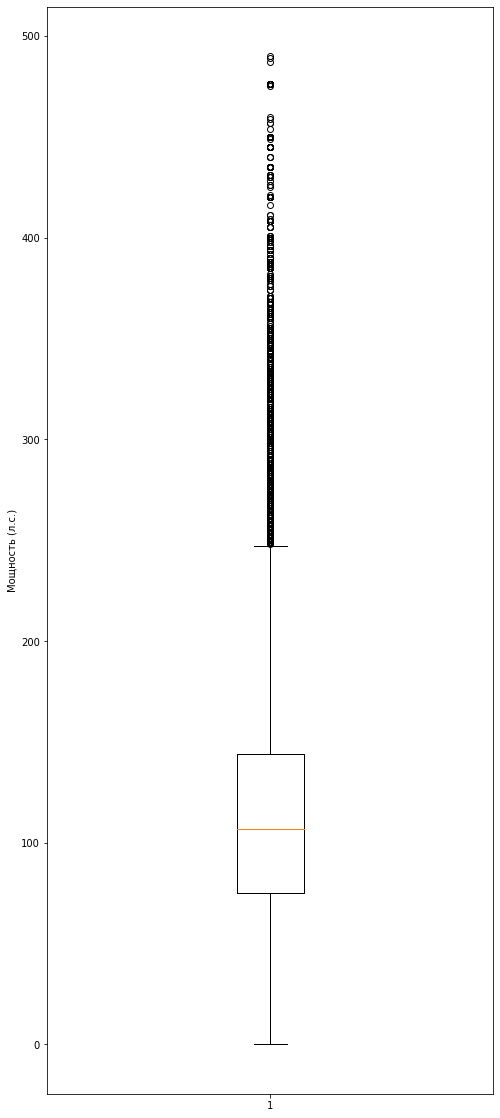

In [41]:
fig, ax = plt.subplots(figsize=(8, 20))
plt.boxplot(autos['Power'])
plt.ylabel('Мощность (л.с.)')
plt.show()

Также в данных есть строки со значением `0` в колонке `Power`. Такие значения также выглядят странно. На графике не видно выбросов в нижней части графика, но предлагаю все-таки удалить значения, меньше 10.

In [42]:
autos = autos[autos['Power'] > 10 ]

##### Признак `RegistrationMonth`

In [43]:
autos['RegistrationMonth'].value_counts().sort_values(ascending=False)

3     29176
6     26204
4     24551
5     24394
7     22651
10    21968
12    20234
11    20200
9     20103
1     19239
8     18823
2     17980
0     14420
Name: RegistrationMonth, dtype: int64

Значения, равные 0, являются аномальными. Удалим их.

In [44]:
autos = autos[autos['RegistrationMonth'] != 0]

In [45]:
autos = autos.reset_index().drop('index', axis=1)

In [46]:
autos.shape

(265523, 16)

Мы выполнили обработку аномалий в данных: столбцы `Price`, `RegistrationYear`, `RegistrationMonth` и `Power`.

### Изучение корреляции признаков

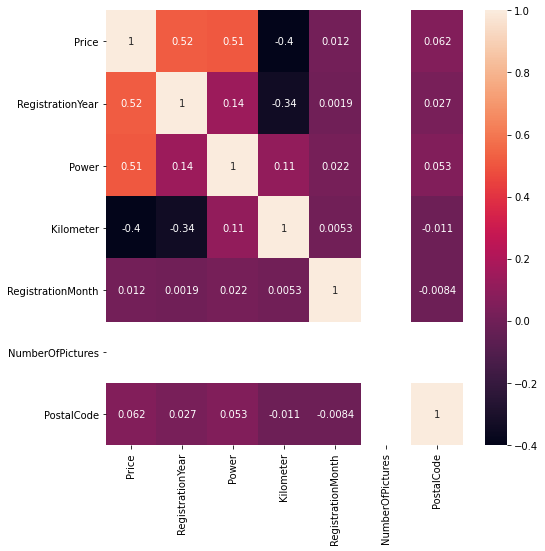

In [47]:
fig, ax = plt.subplots(figsize=(8,8))  
sns.heatmap(autos.corr(), annot=True)
plt.show()

Видим, что с целевыми признаков `Price` больше всего коррелируют следующие (числовые) признаки:
- `RegstrationYear`: $corr = 0.52$
- `Power`: $corr = 0.51$
- `Kilometer`: $corr = -0.4$

В признаках не наблюдается мультиколлинеарность.

### Отбор признаков
Не все признаки будут одинаково полезны для обучения. Предлагаю оставить следующие признаки:
- `VehicleType`: категориальный признак.
- `RegistrationYear`: категориальный признак.
- `Gearbox`: категориальный признак.
- `Power`.
- `Model`: категориальный признак.
- `Kilometer`.
- `FuelType`: категориальный признак.
- `Brand`: категориальный признак.
- `Repaired`: категориальный признак.

In [48]:
features = autos[['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']]

In [49]:
target = autos['Price']

### Выводы по этапу подготовки данных

Нами был выполнен этап подготовки данных. Данные были зыгружены в датафрейм `autos`. Датафрейм содержал 354369 строк-наблюдений. В данных 16 колонок:

- `DateCrawled`: строковые данные, пропусков нет. Данные были преобразованы в тип `datetime`.
- `Price`: целочисленные данные типа `int64`, пропусков нет. Из данных были удалены аномальные значения меньше 11.
- `VehicleType`: строковые данные, 37490 пропусков. Пропуски были заменены на заглушку `unknown`.
- `RegistrationYear`: целочисленные данные типа `int64`, пропусков нет. Из данных были удалены аномальные значения, меньше 1910 и больше 2019.
- `Gearbox`: строковые данные, 19833 пропусков. Пропуски были удалены.
- `Power`: целочисленные данные типа `int64`, пропусков нет. Были удалены аномальные значения, большие 500 л.с. и меньше 10 л.с.
- `Model`:  строковые данные, 19705 пропусков. Пропуски были удалены.
- `Kilometer`: целочисленные данные типа `int64`, пропусков нет. 
- `RegistrationMonth`: целочисленные данные типа `int64`, пропусков нет. Были удалены аномальные значения, равные 0.
- `FuelType`: строковые данные, 32895 пропусков. Пропуски были заменены на заглушку `unknown`.
- `Brand`: строковые данные, пропусков нет.
- `Repaired`: строковые данные, 71154 пропусков. Пропуски были заменены на заглушку `unknown`.
- `DateCreated`: строковые данные, пропусков нет. Данные были преобразованы в тип `datetime`.
- `NumberOfPictures`: целочисленные данные типа `int64`, пропусков нет. 
- `PostalCode`: целочисленные данные типа `int64`, пропусков нет.

Из данных были удалены 4 строки-дубликата.

Была изучена корреляция признаков с целевым признаком. С целевыми признаков `Price` больше всего коррелируют следующие (числовые) признаки:
- `RegstrationYear`: $corr = 0.52$
- `Power`: $corr = 0.51$
- `Kilometer`: $corr = -0.4$

Для обучения были отобраны следующие признаки:
- `VehicleType`: категориальный признак.
- `RegistrationYear`: категориальный признак.
- `Gearbox`: категориальный признак.
- `Power`.
- `Model`: категориальный признак.
- `Kilometer`.
- `FuelType`: категориальный признак.
- `Brand`: категориальный признак.
- `Repaired`: категориальный признак.

## Обучение моделей

### Разделение на train/valid/test
Разделим наши данные на train/valid/test в отношении 3:1:1.

In [50]:
features_train, features_validtest, target_train, target_validtest = train_test_split(
    features, target, test_size=0.4, random_state=1)

In [51]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_validtest, target_validtest, test_size=0.5, random_state=1)

In [52]:
for df in [features_train, target_train, features_valid, target_valid, features_test, target_test]:
    print(df.shape)

(159313, 9)
(159313,)
(53105, 9)
(53105,)
(53105, 9)
(53105,)


### Обработка категориальных признаков
Библиотека `LightGBM` умеет работать с категориальными признаками, но мы будем использовать не только ее, поэтому предлагаю закодировать категориальные признаки.

Отберем признаки для кодирования.

In [53]:
encoded_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Воспользуемся OrdinalEncoder для деревьев.

In [54]:
oe = OrdinalEncoder(handle_unknown='ignore')

In [55]:
features_oe_train = oe.fit_transform(features_train)

In [56]:
features_oe_valid = oe.transform(features_valid)
features_oe_test = oe.transform(features_test)

Воспользуемся OneHotEncoder для линейной модели.

In [57]:
#ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [58]:
ohe.fit(features_train[encoded_features])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [59]:
features_ohe_train = features_train.copy()
features_ohe_valid = features_valid.copy()
features_ohe_test = features_test.copy()

In [60]:
features_ohe_train[ohe.get_feature_names()] = ohe.transform(features_train[encoded_features])

In [61]:
features_ohe_valid[ohe.get_feature_names()] = ohe.transform(features_valid[encoded_features])
features_ohe_test[ohe.get_feature_names()] = ohe.transform(features_test[encoded_features])

In [62]:
features_ohe_train = features_ohe_train.drop(encoded_features, axis=1)
features_ohe_valid = features_ohe_valid.drop(encoded_features, axis=1)
features_ohe_test = features_ohe_test.drop(encoded_features, axis=1)

### Масштабирование признаков
Для линейной регрессии стоит выполнить масштабирование линейных переменных.

In [63]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159313 entries, 218466 to 128037
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       159313 non-null  object
 1   RegistrationYear  159313 non-null  int64 
 2   Gearbox           159313 non-null  object
 3   Power             159313 non-null  int64 
 4   Model             159313 non-null  object
 5   Kilometer         159313 non-null  int64 
 6   FuelType          159313 non-null  object
 7   Brand             159313 non-null  object
 8   Repaired          159313 non-null  object
dtypes: int64(3), object(6)
memory usage: 12.2+ MB


In [64]:
num_features = ['RegistrationYear', 'Power', 'Kilometer']

In [65]:
scaler = StandardScaler()

In [66]:
features_ohe_train[num_features] = scaler.fit_transform(features_ohe_train[num_features])

In [67]:
features_ohe_valid[num_features] = scaler.transform(features_ohe_valid[num_features])
features_ohe_test[num_features] = scaler.transform(features_ohe_test[num_features])

### Модель линейной регрессии
Сначала обучим модель линейной регрессии.

In [68]:
model = LinearRegression()

In [69]:
%%time
model.fit(features_ohe_train, target_train)

CPU times: user 13.9 s, sys: 19.1 s, total: 33 s
Wall time: 33 s


LinearRegression()

In [70]:
%%time
predict_valid = model.predict(features_ohe_valid)

CPU times: user 94.2 ms, sys: 134 ms, total: 229 ms
Wall time: 213 ms


In [71]:
rmse = mean_squared_error(target_valid, predict_valid, squared=False)
print('RMSE =', rmse)

RMSE = 2522.878531086929


Полученное значение RMSE ниже значения, заявленного в задаче, модель линейной регресси не подходит.

### Модель LightGBM

In [72]:
%%time
rmse_best = 2522
best_gbm = model
for lr in [0.05, 0.01 ]:
    print(f'Learning rate = {lr}')
    for n_est in [50, 100]:
        print(f'Number of estimators = {n_est}')
        gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        n_estimators=n_est,
                        learning_rate=lr)
        gbm.fit(features_oe_train, target_train,
                eval_set=[(features_oe_valid, target_valid)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(5)])
        predict_valid = gbm.predict(features_oe_valid, num_iteration=gbm.best_iteration_)
        rmse = mean_squared_error(target_valid, predict_valid, squared=False)
        if rmse_best > rmse:
            rmse_best = rmse
            best_gbm = gbm

Learning rate = 0.05
Number of estimators = 50
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 1979.49	valid_0's l2: 3.91839e+06
Number of estimators = 100
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1766.92	valid_0's l2: 3.12199e+06
Learning rate = 0.01
Number of estimators = 50
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 3378.29	valid_0's l2: 1.14129e+07
Number of estimators = 100
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 2689.05	valid_0's l2: 7.23099e+06
CPU times: user 3min 41s, sys: 1.51 s, total: 3min 43s
Wall time: 3min 45s


In [73]:
best_gbm

LGBMRegressor(learning_rate=0.05, objective='regression')

In [74]:
%%time
predict_valid = best_gbm.predict(features_oe_valid, num_iteration=best_gbm.best_iteration_)

CPU times: user 446 ms, sys: 0 ns, total: 446 ms
Wall time: 394 ms


In [75]:
rmse = mean_squared_error(target_valid, predict_valid, squared=False)
print('RMSE =', rmse)

RMSE = 1766.916073991353


Модель бустинга продемонстрировала RMSE = 1767 с гиперпараметрами learning_rate=0.05, n_estimators=100.

### Модель RandomForestClassifier

In [76]:
rfr = RandomForestRegressor(random_state=1, n_estimators=200, max_features='sqrt')

In [77]:
%%time
rfr.fit(features_oe_train, target_train)

CPU times: user 34.3 s, sys: 964 ms, total: 35.3 s
Wall time: 35.3 s


RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)

In [78]:
%%time
predict_valid = rfr.predict(features_oe_valid)

CPU times: user 4.19 s, sys: 28.3 ms, total: 4.21 s
Wall time: 4.22 s


In [79]:
rmse = mean_squared_error(target_valid, predict_valid, squared=False)
print('RMSE =', rmse)

RMSE = 1553.1837613838707


Мы получили значение RMSE = 1553 при использовании RandomForestRegressor с гиперпараметрами `max_features`=`sqrt`, `n_estimators`=200. Это лучший результат.

## Анализ моделей

Сначала измерим время обучения для LGBMRegressor c лучшими параметрами.

In [80]:
lgbm = LGBMRegressor(learning_rate=0.05, objective='regression')

In [81]:
%%time
lgbm.fit(features_oe_train, target_train)

CPU times: user 39.5 s, sys: 282 ms, total: 39.7 s
Wall time: 40.2 s


LGBMRegressor(learning_rate=0.05, objective='regression')

In [82]:
%%time
predict_valid = lgbm.predict(features_oe_valid)

CPU times: user 451 ms, sys: 0 ns, total: 451 ms
Wall time: 485 ms


In [83]:
rmse = mean_squared_error(target_valid, predict_valid, squared=False)
print('RMSE =', rmse)

RMSE = 1766.916073991353


Мы обучили три модели регрессии и измерили качество этих моделей на валидационных выборках. Для оценки качества была использовала метрика RMSE. Результаты представлены в таблице ниже.

|Модель|RMSE|Время обучения|Время предсказания|
|------|---:|-------------------|------------------|
|Линейная регрессия|2523|33 s|213 ms|
|LightGBM|1767|40.2 s|485 ms|
|Случайный лес|1553|35.3 s|4.22 s|

Наилучший результат продемонстрировала модель RandomForestRegressor с гиперпараметрами `max_features`=`sqrt`, `n_estimators`=200. Она также продемострировала среднюю скорость, т.е. обучается быстрее грандиентного бустинга, но медленнее линейной регрессии. Таким образом, оптимальной моделью является модель случайного леса.

Протестируем ее на тестовых данных.

In [84]:
%%time
predict_test = rfr.predict(features_oe_test)

CPU times: user 4.13 s, sys: 20.2 ms, total: 4.15 s
Wall time: 4.19 s


In [85]:
rmse = mean_squared_error(target_test, predict_test, squared=False)
print('RMSE =', rmse)

RMSE = 1533.1644968151231


На тестовой выборке модель продемонстировала RMSE = 1533.

## Проверка на адекватность

In [86]:
dummy_regressor = DummyRegressor()

In [87]:
%%time
dummy_regressor.fit(features_oe_train, target_train)

CPU times: user 0 ns, sys: 1.17 ms, total: 1.17 ms
Wall time: 868 µs


DummyRegressor()

In [88]:
%%time
dummy_predict = dummy_regressor.predict(features_oe_test)

CPU times: user 204 µs, sys: 89 µs, total: 293 µs
Wall time: 313 µs


In [89]:
rmse = mean_squared_error(target_test, dummy_predict, squared=False)
print('RMSE =', rmse)

RMSE = 4638.707981393021


Выбранная нами модель проходит проверку на адекватность.

## Выводы

Была обучена и протестирована модель для определения стоимости автомобилей. Работа выполнялась в несколько этапов.
1. На первом этапе была проведена подготовка данных. Данные были зыгружены в датафрейм `autos`. Датафрейм содержал 354369 строк-наблюдений. В данных 16 колонок:

    - `DateCrawled`: строковые данные, пропусков нет. Данные были преобразованы в тип `datetime`.
    - `Price`: целочисленные данные типа `int64`, пропусков нет. Из данных были удалены аномальные значения меньше 11.
    - `VehicleType`: строковые данные, 37490 пропусков. Пропуски были заменены на заглушку `unknown`.
    - `RegistrationYear`: целочисленные данные типа `int64`, пропусков нет. Из данных были удалены аномальные значения, меньше 1910 и больше 2019.
    - `Gearbox`: строковые данные, 19833 пропусков. Пропуски были удалены.
    - `Power`: целочисленные данные типа `int64`, пропусков нет. Были удалены аномальные значения, большие 500 л.с. и меньше 10 л.с.
    - `Model`:  строковые данные, 19705 пропусков. Пропуски были удалены.
    - `Kilometer`: целочисленные данные типа `int64`, пропусков нет. 
    - `RegistrationMonth`: целочисленные данные типа `int64`, пропусков нет. Были удалены аномальные значения, равные 0.
    - `FuelType`: строковые данные, 32895 пропусков. Пропуски были заменены на заглушку `unknown`.
    - `Brand`: строковые данные, пропусков нет.
    - `Repaired`: строковые данные, 71154 пропусков. Пропуски были заменены на заглушку `unknown`.
    - `DateCreated`: строковые данные, пропусков нет. Данные были преобразованы в тип `datetime`.
    - `NumberOfPictures`: целочисленные данные типа `int64`, пропусков нет. 
    - `PostalCode`: целочисленные данные типа `int64`, пропусков нет.

    Из данных были удалены 4 строки-дубликата.

    Была изучена корреляция признаков с целевым признаком. С целевыми признаков `Price` больше всего коррелируют следующие (числовые) признаки:
    - `RegstrationYear`: $corr = 0.52$
    - `Power`: $corr = 0.51$
    - `Kilometer`: $corr = -0.4$

    Для обучения были отобраны следующие признаки:
    - `VehicleType`: категориальный признак.
    - `RegistrationYear`: категориальный признак.
    - `Gearbox`: категориальный признак.
    - `Power`.
    - `Model`: категориальный признак.
    - `Kilometer`.
    - `FuelType`: категориальный признак.
    - `Brand`: категориальный признак.
    - `Repaired`: категориальный признак.
    
    
2. Вторым этапом стало обучение моделей. Были обработаны категориальные признаки: признаки `Gearbox`, `Repaired` были преобразованы с помощью one hot encoding, признаки `VehicleType`, `Model`, `Brand`, `FuelType` были закодированы label encoder-ом. Данные были разделены на обучающую, валидационную и тестовую выборки в отношении 3:1:1. Затем были обучены три модели. Результаты представлены в таблице ниже.


3. Мы проанализировали полученны нами результаты, представленные в таблице ниже.

    |Модель|RMSE|Время обучения|Время предсказания|
    |------|---:|-------------------|------------------|
    |Линейная регрессия|2523|33 s|213 ms|
    |LightGBM|1767|40.2 s|485 ms|
    |Случайный лес|1553|35.3 s|4.22 s|

    Наилучший результат продемонстрировала модель RandomForestRegressor с гиперпараметрами `max_features`=`sqrt`, `n_estimators`=200. Она также продемострировала среднюю скорость, т.е. обучается быстрее грандиентного бустинга, но медленнее линейной регрессии. Таким образом, оптимальной моделью является модель случайного леса.
    
    Модель была протестирована на тестовых данных. Было получено значение метрики RMSE = 1533.
